<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S74_drone_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.drone import axes
from gtbook.display import show
from gtbook.html import HTML
import gtsam.utils.plot as gtsam_plot

# Visual SLAM

> When we do SLAM with cameras, we call it visual SLAM.

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(7, 4, "steampunk", 1))

## Visual SLAM

Visual SLAM *almost* the same problem as the "SLAM with Landmarks" problem from Section 6.4, but we will now use 3D poses and 3D points, and we will use the inertial measurements from the IMU to inform us about the movement of the platform. This is a typical pipeline on drones, phones, etc, everything with an IMU.

### Integrating the IMU

We start off by encoding the information provided by the inertial measurement unit (IMU) in a factor graph.

As an example in code, below we define a scenario with forward velocity 2m/s, while pitching up
with angular velocity 30 degree/sec (negative in FLU). We set up a simulation using a class called the `ScenarioRunner`.

In [12]:
# Set up the scenario with a constant velocity model, both angular (W) and linear (V)
W = np.array([0, -np.radians(30), 0])
V = np.array([2, 0, 0])
scenario = gtsam.ConstantTwistScenario(W, V)

# Create noise parameters
params = gtsam.PreintegrationParams.MakeSharedU(9.8)
kGyroSigma = np.radians(0.5) / 60  # 0.5 degree ARW
kAccelSigma = 0.1 / 60  # 10 cm VRW
params.setGyroscopeCovariance(kGyroSigma**2 * np.identity(3, float))
params.setAccelerometerCovariance(kAccelSigma**2 *
                                    np.identity(3, float))
params.setIntegrationCovariance(0.0000001**2 * np.identity(3, float))

# Create bias parameters
accBias = np.array([0, 0.1, 0]) # bias in accelerometer
gyroBias = np.array([0, 0, 0]) # bias in gyroscope
bias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

# Instantiate IMU simulation class as `runner`
dt = 0.1 # 10 Hz
runner = gtsam.ScenarioRunner(scenario, params, dt, bias)

GTSAM contains a powerful, state of the art factor called the `ImuFactor` that allows us to accumulate IMU measurements and periodically add the resulting relative pose information to the graph. The accumulation of (high-rate) IMU measurements is done in a class called `PreintegratedImuMeasurements`, abbreviated "PIM".

In [5]:
# Create graph
X = gtsam.symbol_shorthand.X
V = gtsam.symbol_shorthand.V
imu_graph = gtsam.NonlinearFactorGraph()
state = scenario.navState(0)
Iso = gtsam.noiseModel.Isotropic
imu_graph.addPriorPose3(X(0), state.pose(), Iso.Sigma(6, 0.1))
imu_graph.addPriorVector(V(0), state.velocity(), Iso.Sigma(3, 0.1))
BIAS_KEY = gtsam.symbol('b', 0)
imu_graph.addPriorConstantBias(BIAS_KEY, bias, Iso.Sigma(6, 0.1))

i = 0
imu_initial = gtsam.Values()
imu_initial.insert(BIAS_KEY, bias)
imu_initial.insert(X(0), state.pose())
imu_initial.insert(V(0), state.velocity())

T=3.5
# initialize data structure for pre-integrated IMU measurements
pim = gtsam.PreintegratedImuMeasurements(params, bias)
for j, t in enumerate(np.arange(0, T, dt)):
    measuredOmega = runner.measuredAngularVelocity(t)
    measuredAcc = runner.measuredSpecificForce(t)
    pim.integrateMeasurement(measuredAcc, measuredOmega, dt)
    if j>0 and j % 5 == 0:
        # create IMU factor
        factor = gtsam.ImuFactor(X(i), V(i), X(i + 1), V(i + 1), BIAS_KEY, pim)
        imu_graph.push_back(factor)
        i += 1
        state = scenario.navState(t)
        imu_initial.insert(X(i), state.pose().retract(np.random.normal(scale=0.1, size=(6,))))
        imu_initial.insert(V(i), state.velocity() + np.random.normal(scale=0.1, size=(3,)))
        pim.resetIntegration()

The graph displayed below shows (a bit messily) that the IMUFactors tie together the `Pose3` states $x_k$, the velocities $v_k$m and the unknown IMU biases $b_0$.

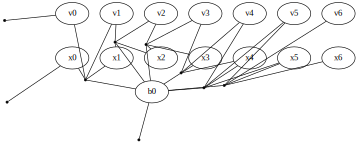

In [6]:
position_hints = {'u': 2, 'x': 1, 'z': 0}
position_hints.update({'v':2})
show(imu_graph, gtsam.Values(), hints=position_hints)

We can optimize even *without* any external measurements, but unless you pay for a very expensive IMU, your estimate will drift very rapidly.

In [7]:
print(f"initial error: {imu_graph.error(imu_initial)}")
try:
    lm = gtsam.LevenbergMarquardtOptimizer(imu_graph, imu_initial)
    imu_result = lm.optimize()
except RuntimeError:
    print("LM Optimization failed")
print(f"final error: {imu_graph.error(imu_result)}")

initial error: 12092756.685792536
final error: 1.211620035298905e-23


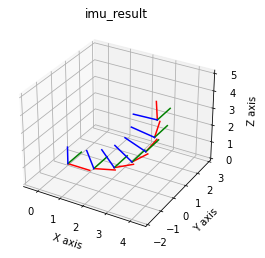

In [8]:
i = 0
while imu_result.exists(X(i)):
    gtsam_plot.plot_pose3(1, imu_result.atPose3(X(i)), 1)
    i += 1
plt.title("imu_result")
gtsam.utils.plot.set_axes_equal(1)

### Incorporating Visual Measurements

TBD, but see [this example](https://gtbook.github.io/gtsam-examples/StereoVOExample_large.html).

## Structure from Motion

![Balbianello](https://github.com/gtbook/robotics/blob/main/Figures7/Balbianello.jpg?raw=1 "Balbianello")

Structure from Motion, or SfM, is the problem of reconstructing 3D structure from multiple images, even when taken from different cameras or at different times. In the figure above we show one such sequence, 5 images of the "Balbianello" villa in Italy, situated on lake Como.



SfM is almost the same problem as Visual SLAM, but typically there is no odometry between cameras. The optimization problem is also called **Bundle Adjustment**. Arguably, the most difficult problem associated with SfM is feature detection, data association, and initializing the optimization.

Below we load the Balbianello data from file and create factor graph as well as an initial estimate.

In [9]:
filename = gtsam.findExampleDataFile("Balbianello.out")
sfm_data = gtsam.SfmData.FromBundlerFile(filename)
model = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v
graph = sfm_data.sfmFactorGraph(model)
initial = gtsam.initialCamerasAndPointsEstimate(sfm_data)
print(f"initial error: {graph.error(initial)}")

initial error: 126.92834251964683


We then optimize, as usual, now performing structure from motion: we optimize for both the unknown camera poses (calibration is assumed known here) and the unknown 3D points in the scene.


In [10]:
try:
    lm = gtsam.LevenbergMarquardtOptimizer(graph, initial)
    result = lm.optimize()
except RuntimeError:
    print("LM Optimization failed")
print(f"final error: {graph.error(result)}")

final error: 125.51738267205192


The result of SfM is a sparse point cloud and a set of well-determined camera poses and camera calibration, which can be densified using multi-view stereo techniques. This is out of scope of this chapter, however, and below we simply extract the 3D points and display them in 3D with `plotly`.

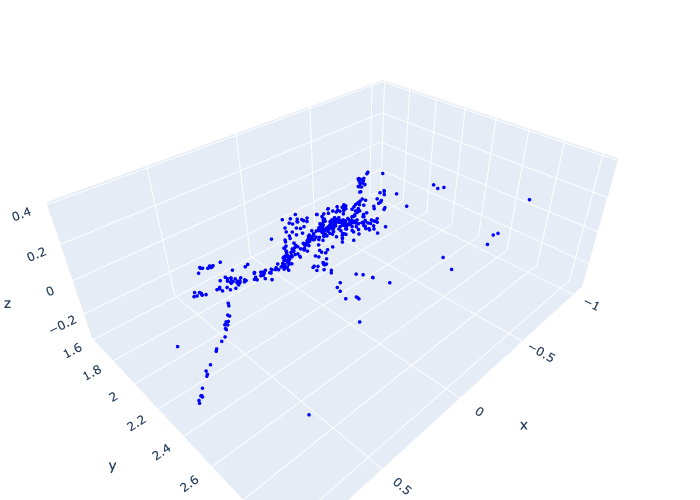

In [11]:
structure = gtsam.utilities.extractPoint3(result)
valid = structure[:,2] > -5.0
bRc = sfm_data.camera(0).pose().rotation()
wRc = gtsam.Rot3([1,0,0],[0,0,-1],[0,1,0]) # make camera point to world y
wRb = wRc.compose(bRc.inverse())
structure = (wRb.matrix() @ structure.T).T

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=structure[valid,0],y=structure[valid,1],z=structure[valid,2], 
    mode="markers", marker=dict(size=2, color="blue"), showlegend= False))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()